In [2]:
import pandas as pd
import numpy as np

import scipy as sp
import sklearn as sk

import random
import time
from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output


In [3]:
#common model algorithms
from sklearn import svm, tree, gaussian_process, linear_model, ensemble
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from xgboost import XGBRegressor
#from xgboost import plot_importance

#common model help tools
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

#Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

#set visual parameters
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 16,8

In [4]:
PATH1 = "C:/Users/kpunyakoti/Desktop/Data Science/Kaggle/Housing Prices/Source Data files/"   #where you read the files from
PATH2 = "C:/Users/kpunyakoti/Desktop/Data Science/Kaggle/Housing Prices/Submissions/"   #where you export the files to
df_train = pd.read_csv(f'{PATH1}clean2_train_data.csv', index_col='Id')
df_test = pd.read_csv(f'{PATH1}clean2_test_data.csv', index_col='Id')
play_data = df_train.copy()

FileNotFoundError: [Errno 2] File b'C:/Users/kpunyakoti/Desktop/Data Science/Kaggle/Housing Prices/Source Data files/clean2_train_data.csv' does not exist: b'C:/Users/kpunyakoti/Desktop/Data Science/Kaggle/Housing Prices/Source Data files/clean2_train_data.csv'

In [24]:
#define y variable aka target/outcome
Target = play_data['SalePrice']
train_data = play_data.drop('SalePrice', axis=1)
test_data = df_test.copy()

In [25]:
print(test_data.shape)
print(train_data.shape)
#test_data = test_data.drop('SalePrice', axis =1)

(1459, 77)
(1460, 77)


In [26]:
train_data['trainingset'] = True
test_data['trainingset'] = False
df_full = pd.concat([train_data, test_data])
df_full['GarageYrBlt'] = df_full['GarageYrBlt'].astype(str)

In [349]:
cat_cols = ['MSSubClass','OverallQual','OverallCond','BsmtFullBath','FullBath','BsmtHalfBath','HalfBath',
           'BedroomAbvGr','TotRmsAbvGrd','KitchenAbvGr','Fireplaces','GarageCars', 'GarageYrBlt']
for x in cat_cols:
    df_full[x] = df_full[x].apply(str) 

In [27]:
df_full = df_full.interpolate()
df_full = pd.get_dummies(df_full)

train_data = df_full[df_full['trainingset']== True]
train_data = train_data.drop('trainingset', axis=1)
test_data = df_full[df_full['trainingset']== False]
test_data = test_data.drop('trainingset', axis=1)


In [28]:
print(train_data.shape)
print(test_data.shape)

(1460, 404)
(1459, 404)


Feature Ranking
--

In [223]:
feat_rank = XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

<Figure size 864x28800 with 0 Axes>

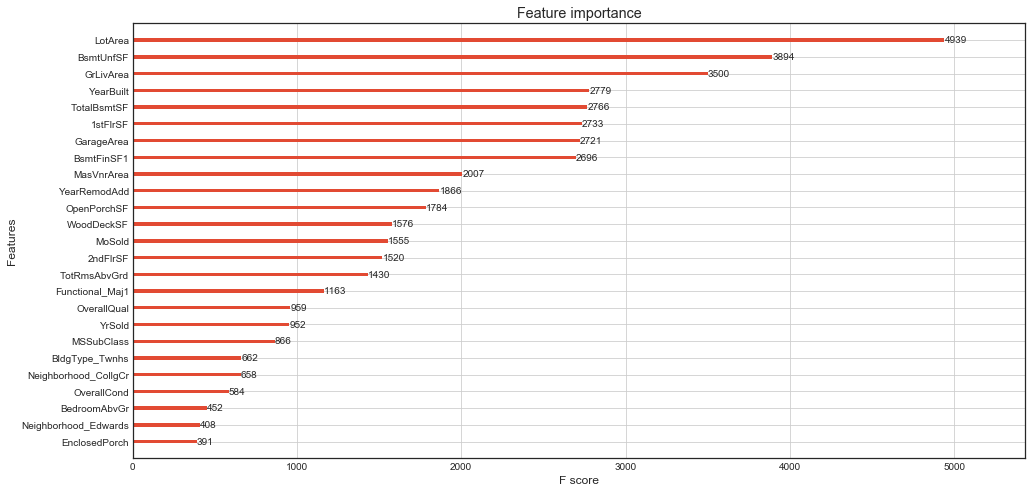

In [224]:
every_column_except_y= [col for col in train_data.columns if col not in ['Id']]
feat_rank.fit(train_data[every_column_except_y],Target)
plt.figure(figsize=[12,400])
#print(feat_rank.feature_importances_)
# plot
plot_importance(feat_rank,max_num_features=25)

In [ ]:
most_imp_features = list( dict((k, v) for k, v in feat_rank.booster().get_fscore().items() if v >= 10).keys())
print(most_imp_features)

Model Comparision
--

In [111]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostRegressor(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),
    #Gaussian Processes
    #gaussian_process.GaussianProcessRegressor(),  
    #GLM
    #linear_model.LinearRegression(),
    #linear_model.Lasso(),
    linear_model.RidgeCV(),
    linear_model.ElasticNetCV(),    
    #Trees
    tree.DecisionTreeRegressor()
]

In [29]:
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 20, train_size = .7, test_size = .3, 
                                        random_state = 0)#run model 10 times with 60%train data and 30%test data leaving 10%

In [240]:
#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 
               'MLA Test Accuracy 3*STD', 'MLA Time', 'MLA RMSE']
MLA_compare = pd.DataFrame(columns=MLA_columns)
#create table for MLA Predict
MLA_predict = Target
#index through MLA and ave performance to table
row_index=0
for alg in MLA:          
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name    
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params()) #set name and params
        #score model with cross validation
    cv_results = model_selection.cross_validate(alg, train_data, Target, cv=cv_split)    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
        #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, 
        #should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3
    MLA_compare.loc[row_index, 'MLA RMSE'] = np.sqrt(((cv_results['test_score']-cv_results['train_score'])**2).mean())    
    alg.fit(train_data, Target)
    MLA_predict = alg.predict(train_data)    
    row_index+=1
#print and sort table

MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace=True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time,MLA RMSE
1,GradientBoostingRegressor,"{'alpha': 0.9, 'criterion': 'friedman_mse', 'i...",0.972457,0.916427,0.0272727,0.929669,0.0568985
3,RidgeCV,"{'alphas': (0.1, 1.0, 10.0), 'cv': None, 'fit_...",0.939584,0.8963,0.0534983,0.232063,0.0475837
2,RandomForestRegressor,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",0.977401,0.87825,0.0446247,0.316594,0.100235
0,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 1.0,...",0.891477,0.838619,0.039282,0.549501,0.0550274
5,DecisionTreeRegressor,"{'criterion': 'mse', 'max_depth': None, 'max_f...",1,0.766447,0.136824,0.0497308,0.237964
4,ElasticNetCV,"{'alphas': None, 'copy_X': True, 'cv': None, '...",0.665445,0.662126,0.0730645,0.20997,0.026899


In [ ]:
#barplot for Test Accuracy Mean
plt.subplots(figsize=[12,6])
sns.barplot(x='MLA RMSE', y='MLA Name', data=MLA_compare, color = 'c')

plt.title('Machine Learning Algorithm Accuracy score \n')
plt.xlabel('RMSE Score')
plt.ylabel('Algorithm')

Tuning
--

In [ ]:
#tune gradientboostingregressor to tune the model

grad = GradientBoostingRegressor()
base_results = model_selection.cross_validate(grad, train_data, Target, cv = cv_split)
grad.fit(train_data, Target)

print('-----Before Tuning-----')
print('parameters:', grad.get_params())
print('Training score mean: {:,.2f}'.format(base_results['train_score'].mean()*100))
print('Test score mean: {:,.2f}'.format(base_results['test_score'].mean()*100))
print('RMSE: {:,.4f}'.format(np.sqrt(((base_results['test_score']-base_results['train_score'])**2).mean())))
print('-'*20)
print('-'*20)

# Use a grid over parameters of interest
""""param_grid = {"criterion": ['friedman_mse','mse'],
              "n_estimators" : [32, 64, 100, 150, 200],
              #"learning_rate" : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
           "max_depth" : [5, 10, 15],
           "min_samples_leaf" : [1, 2],
             "min_samples_split" : [2,4,8,10]}


tuned_model2 = GradientBoostingRegressor()
tuned_model2 = model_selection.GridSearchCV(tuned_model, 
                                          param_grid=param_grid, cv = cv_split)
tuned_model2.fit(train_data,Target)
print('-----After Tuning-----')
print('parameters:', new_tuned_model.best_params_)
print('Training score mean: {:,.2f}'.format(tuned_model2.cv_results_['mean_train_score'][tuned_model2.best_index_].mean()*100))
print('Test score mean: {:,.2f}'.format(tuned_model2.cv_results_['mean_test_score'][tuned_model2.best_index_].mean()*100))
print('RMSE: {:,.4f}'.format(np.sqrt(((tuned_model2['test_score']-tuned_model2['train_score'])**2).mean())))
print('-'*20)"""

In [142]:
grad2 = GradientBoostingRegressor(criterion = 'friedman_mse', n_estimators = 120, max_depth = 3, loss = 'ls',
                                  min_samples_leaf = 1, min_samples_split =2, learning_rate = 0.09)
base_results = model_selection.cross_validate(grad2, train_data, Target, cv = cv_split)
grad2.fit(train_data, Target)

print('-----Tuned Model-----')
print('parameters:', grad.get_params())
print('Training score mean: {:,.2f}'.format(base_results['train_score'].mean()*100))
print('Test score mean: {:,.2f}'.format(base_results['test_score'].mean()*100))
print('RMSE: {:,.4f}'.format(np.sqrt(((base_results['test_score']-base_results['train_score'])**2).mean())))
print('-'*20)
print('-'*20)




-----Tuned Model-----
parameters: {'alpha': 0.9, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': None, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}
Training score mean: 97.66
Test score mean: 91.27
RMSE: 0.0644
--------------------
--------------------


Another way of training Model
--

In [30]:
def train_model(train_data, learning_rate, est):
    lr = float(learning_rate)
    est = int(est)
    print('Training Model...')
    #grad3 = GradientBoostingRegressor(n_estimators = est, learning_rate = lr)
    model = XGBRegressor(n_estimators = est, learning_rate = lr)
    """"colsample_bytree=0.4,
                 gamma=0,                 
                # learning_rate=lr,
                 max_depth=3,
                 min_child_weight=1.5,
                # n_estimators=est,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)"""
    base_results = model_selection.cross_validate(model, train_data, Target, cv = cv_split)
    #for period in range(0, period):
        #for i in range(int(steps_per_period)):         
    model.fit(train_data, Target)
    train_score_mean = base_results['train_score'].mean()*100
    test_score_mean = base_results['test_score'].mean()*100
    rmse = np.sqrt(((base_results['test_score']-base_results['train_score'])**2).mean())
    print ("train_acc: {}, test_acc: {}, rmse: {}".format(train_score_mean, test_score_mean, rmse))
    print("Model Training Completed")  
    return model

In [32]:
trained_model = train_model(train_data = train_data, 
                           learning_rate = 0.07,
                           est = 900)     

Training Model...
train_acc: 99.55086556921943, test_acc: 87.40830273645255, rmse: 0.13368085559879225
Model Training Completed


In [ ]:
train_data.to_csv(f'{PATH2}train_data_interpol.csv', index=False)

Output Predictions
--

In [121]:
#predictions 1
preds = tuned_model.predict(test_data)
submit = pd.DataFrame({'Id': test_data.index, 'SalePrice': preds})
submit.to_csv(f'{PATH2}submission_1105_v2.csv', index=False)

In [344]:
#predictions 2
preds = trained_model.predict(test_data)
submit = pd.DataFrame({'Id': test_data.index, 'SalePrice': preds})
submit.to_csv(f'{PATH2}submission_1106_v2.csv', index=False)

Feature Selection (optional)
--

In [ ]:
#select only required features using RFE 
grad4 = GradientBoostingRegressor()
base_results = model_selection.cross_validate(grad4, train_data, Target, cv = cv_split)
grad.fit(train_data, Target)

print('Before GradBst RFE Training shape', train_data.shape)
print('Before GradBst RFE Training Features', train_data.columns.values)

print('Before GradBst Training w/bin score mean: {:,.2f}'.format(base_results['train_score'].mean()*100))
print('Before GradBst Test w/bin score mean: {:,.2f}'.format(base_results['test_score'].mean()*100))
print('Before GradBst Test RMSE:  {:,.4f}'.format(np.sqrt(((base_results['test_score']-base_results['train_score'])**2).mean())))
print('-'*20)

#feature_selection
grad_rfe = feature_selection.RFECV(grad, step =1,  cv = cv_split)
grad_rfe.fit(train_data, Target) #alternatively, you can use pipeline to redue features

x_rfe = train_data.columns.values[grad_rfe.get_support()]
rfe_results = model_selection.cross_validate(grad_rfe, train_data[x_rfe], Target, cv=cv_split)

print('After GradBst RFE New shape', train_data[x_rfe].shape)
print('After GradBst RFE New Features', x_rfe)

print('After GradBst RFE Training w/bin score mean: {:,.2f}'.format(rfe_results['train_score'].mean()*100))
print('After GradBst RFE Test w/bin score mean: {:,.2f}'.format(rfe_results['test_score'].mean()*100))
print('After GradBst RFE Test RMSE:  {:,.4f}'.format(np.sqrt(((rfe_results['test_score']-rfe_results['train_score'])**2).mean())))
print('-'*20)
